# LSTM (Long Short-Term Memory) ile Hisse Senedi Fiyatı Tahminlemesi

1) İş Problemi (Business Problem)

2) Veriyi Anlamak (Data Understanding)

3) Veriyi Hazırlamak (Data Preparation)

4) Modelleme (Modeling)

5) Değerlendirme (Evaluation)

### 1) İş Problemi (Business Problem)

- Tesla hisse senetlerini inceleyerek gelecek tahminlerde bulunulacak.

- **Date:** İlgili işlem gününün tarihini temsil etmektedir.
- **Open:** İlgili işlem günüe ait hisse başlangıç fiyatını temsil etmektedir.
- **High:** İlgili işlem gününe ait en yüksek fiyatı temsil etmektedir
- **Low:** İlgili işlem gününe ait en düşük fiyatı temsil etmektedir.
- **Close:** İlgili işlem gününde hisse senedinin kapanış fiyatını temsil etmektedir.
- **Adj Close:** İlgili işlem gününe ait hisse senedinin düzeltilmiş kapanış fiyatını temsil etmektedir.
- **Volume:** İlgili işlem gününe ait işlem hacmi bilgisini temsil etmektedir.

# 2) Veriyi Anlamak (Data Understanding)

### 2.1) Gerekli Kütüphanelerin Import İşlemleri

In [1]:
# Veriyi okuma ve işleme adımında kullanılacak olan kütüphaneler

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Model değerlendirme ve veriyi scale edebilmemiz için kullanılacak olan kütüphaneler

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Model için kullanılacak olan kütüphaneler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Warningleri kapatmak için kullanılmaktadır.

import warnings
warnings.filterwarnings("ignore")

# Tensorflow Warning Engelleme

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### 2.2) Veri Setinin Yüklenmesi ve Verinin Genel Resminin İncelenmesi

In [3]:
df = pd.read_csv("TSLA.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [5]:
def check_df(dataframe, head=5):
    print("################ Shape ################")
    print(dataframe.shape)
    print("################ Shape ################")
    print(dataframe.dtypes)
    print("################ Shape ################")
    print(dataframe.head(head))
    print("################ Shape ################")
    print(dataframe.tail(head))
    print("################ Shape ################")
    print(dataframe.isnull().sum())
    print("################ Shape ################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


In [6]:
check_df(df)

################ Shape ################
(2416, 7)
################ Shape ################
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
################ Shape ################
         Date       Open   High        Low      Close  Adj Close    Volume
0  2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1  2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2  2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3  2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4  2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900
################ Shape ################
            Date        Open        High         Low       Close   Adj Close  \
2411  2020-01-28  568.489990  576.809998  558.080017  566.900024  566.900024   
2412  2020-01-29  575.690002  589.799988  567.429993  580.9

### 3) Veriyi Hazırlamak (Data Preparation)

In [8]:
df["Date"] = pd.to_datetime(df["Date"])

In [10]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [11]:
tesla_df = df[["Date", "Close"]]

In [12]:
tesla_df.head()

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001


In [13]:
print("Minimum Tarih:", tesla_df["Date"].min())
print("Maksimum Tarih:", tesla_df["Date"].max())

Minimum Tarih: 2010-06-29 00:00:00
Maksimum Tarih: 2020-02-03 00:00:00


In [14]:
tesla_df.index

RangeIndex(start=0, stop=2416, step=1)

In [15]:
tesla_df.index = tesla_df["Date"]

In [16]:
tesla_df

,Date,Close
Date,,
2010-06-29,2010-06-29,23.889999
2010-06-30,2010-06-30,23.830000
2010-07-01,2010-07-01,21.959999
2010-07-02,2010-07-02,19.200001
2010-07-06,2010-07-06,16.110001
...,...,...
2020-01-28,2020-01-28,566.900024
2020-01-29,2020-01-29,580.989990
2020-01-30,2020-01-30,640.809998


In [17]:
tesla_df.drop("Date", axis = 1, inplace = True)

In [18]:
tesla_df

,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001
...,...
2020-01-28,566.900024
2020-01-29,580.989990
2020-01-30,640.809998


In [20]:
result_df = tesla_df.copy() # ileride kullanacağımız için bir kopya oluşturduk.

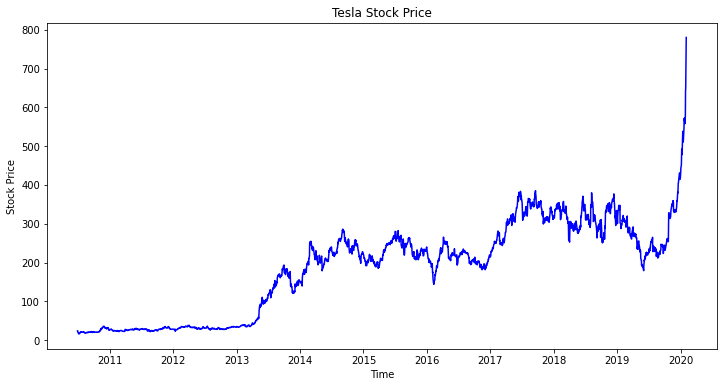

In [21]:
plt.figure(figsize=(12,6))
plt.plot(tesla_df['Close'], color = 'blue');
plt.ylabel('Stock Price')
plt.title('Tesla Stock Price')
plt.xlabel('Time')
plt.show()

In [22]:
tesla_df = tesla_df.values # pandas df' inden numpy array'ine çevirdik

In [23]:
tesla_df

array([[ 23.889999],
       [ 23.83    ],
       [ 21.959999],
       ...,
       [640.809998],
       [650.570007],
       [780.      ]])

In [24]:
tesla_df = tesla_df.astype("float32")

In [25]:
# train-test ayrımının yapılması
# zaman serisi olduğundan scikitlearn'deki random train-test ayrımını yapamayız. kendimiz böleceğiz.

def split_data(dataframe, test_size):
    pos = int(round(len(dataframe)*(1-test_size)))
    train = dataframe[:pos]
    test = dataframe[pos:]
    return train, test, pos

In [26]:
train, test, pos = split_data(tesla_df, 0.20)

In [27]:
print(train.shape, test.shape)

(1933, 1) (483, 1)


In [28]:
scaler_train = MinMaxScaler(feature_range=(0,1))

In [29]:
train = scaler_train.fit_transform(train)

In [30]:
scaler_test = MinMaxScaler(feature_range=(0,1))

In [31]:
test = scaler_test.fit_transform(test)

In [33]:
train[0:5]

array([[0.02191224],
       [0.02174973],
       [0.01668472],
       [0.0092091 ],
       [0.00083966]], dtype=float32)

In [34]:
test[0:5]

array([[0.25685903],
       [0.24829045],
       [0.25511202],
       [0.24978784],
       [0.2465767 ]], dtype=float32)

In [35]:
def create_features(data, lookback):
    X, Y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i,0])
        Y.append(data[i,0])
        
    return np.array(X), np.array(Y)

In [36]:
lookback = 20

In [37]:
# Train Veri Seti
X_train, y_train = create_features(train, lookback)

# Test Veri Seti
X_test, y_test = create_features(test, lookback)

In [38]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1913, 20) (1913,) (463, 20) (463,)


In [39]:
X_train[0:5]

array([[0.02191224, 0.02174973, 0.01668472, 0.0092091 , 0.00083966,
        0.        , 0.00449621, 0.00433369, 0.0033857 , 0.00633803,
        0.01094258, 0.011078  , 0.01310942, 0.0165493 , 0.01218851,
        0.01197183, 0.01408451, 0.01486999, 0.01394908, 0.01286566],
       [0.02174973, 0.01668472, 0.0092091 , 0.00083966, 0.        ,
        0.00449621, 0.00433369, 0.0033857 , 0.00633803, 0.01094258,
        0.011078  , 0.01310942, 0.0165493 , 0.01218851, 0.01197183,
        0.01408451, 0.01486999, 0.01394908, 0.01286566, 0.01332611],
       [0.01668472, 0.0092091 , 0.00083966, 0.        , 0.00449621,
        0.00433369, 0.0033857 , 0.00633803, 0.01094258, 0.011078  ,
        0.01310942, 0.0165493 , 0.01218851, 0.01197183, 0.01408451,
        0.01486999, 0.01394908, 0.01286566, 0.01332611, 0.01232395],
       [0.0092091 , 0.00083966, 0.        , 0.00449621, 0.00433369,
        0.0033857 , 0.00633803, 0.01094258, 0.011078  , 0.01310942,
        0.0165493 , 0.01218851, 0.01197183, 0

In [40]:
y_train[0:5]

array([0.01332611, 0.01232395, 0.01121344, 0.01386782, 0.01665764],
      dtype=float32)

In [41]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1913, 1, 20) (1913, 1) (463, 1, 20) (463, 1)


### 4) Modelleme (Modeling)

In [49]:
model = Sequential()

model.add(LSTM(units = 50,
               activation = 'relu',
               input_shape = (X_train.shape[1], lookback)))

model.add(Dropout(0.2))
model.add(Dense(1))  # çıkışta tek bir nöron beklediğimiz için 1 yazdık.

In [50]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 14,251
Trainable params: 14,251
Non-trainable params: 0
_________________________________________________________________


In [51]:
# Optimizasyon ve Değerlendirme Metrikleri Ayarlanması
model.compile(loss='mean_squared_error', optimizer='adam')

In [52]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience=3, verbose=1, mode= 'min'),
             ModelCheckpoint(filepath='mymodel.h5', monitor = 'val_loss', mode = 'min',
                             save_best_only = True, save_weights_only = False, verbose = 1)]

In [53]:
history = model.fit(x=X_train,
                    y=y_train,
                    epochs = 100,
                    validation_data=(X_test, y_test),
                    callbacks = callbacks,
                    shuffle = False)

Epoch 1/100
39/60 [==================>...........] - ETA: 0s - loss: 0.0134     
Epoch 1: val_loss improved from inf to 0.00363, saving model to mymodel.h5
60/60 [==============================] - 2s 10ms/step - loss: 0.0136 - val_loss: 0.0036
Epoch 2/100
60/60 [==============================] - ETA: 0s - loss: 0.0073
Epoch 2: val_loss improved from 0.00363 to 0.00339, saving model to mymodel.h5
60/60 [==============================] - 0s 4ms/step - loss: 0.0073 - val_loss: 0.0034
Epoch 3/100
56/60 [===========================>..] - ETA: 0s - loss: 0.0065
Epoch 3: val_loss improved from 0.00339 to 0.00306, saving model to mymodel.h5
60/60 [==============================] - 0s 4ms/step - loss: 0.0069 - val_loss: 0.0031
Epoch 4/100
43/60 [====================>.........] - ETA: 0s - loss: 0.0044
Epoch 4: val_loss improved from 0.00306 to 0.00282, saving model to mymodel.h5
60/60 [==============================] - 0s 4ms/step - loss: 0.0061 - val_loss: 0.0028
Epoch 5/100
57/60 [===========

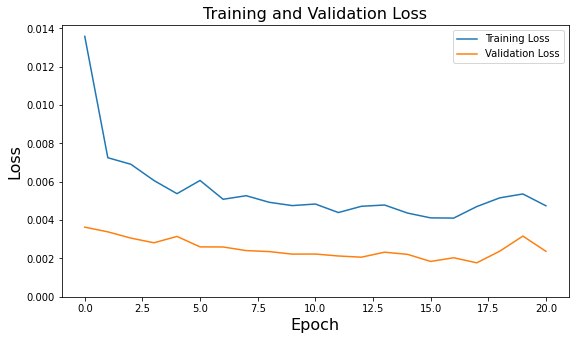

In [54]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epoch", fontsize = 16)
plt.ylabel("Loss", fontsize = 16)
plt.ylim([0, max(plt.ylim())])
plt.title("Training and Validation Loss", fontsize = 16)
plt.show()

### 5) Değerlendirme (Evaluation)

In [55]:
loss = model.evaluate(X_test, y_test, batch_size=20)
print("\nTest loss: %.1f%%" % (100.0 * loss))

24/24 [==============================] - 0s 2ms/step - loss: 0.0024

Test loss: 0.2%


In [56]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

15/15 [==============================] - 0s 1ms/step


In [57]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [58]:
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [59]:
# Train veri setine ait RMSE değeri

train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))

In [60]:
# Test veri setine ait RMSE değeri
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

In [61]:
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 18.551284790039062
Test RMSE: 29.271074295043945


In [62]:
train_prediction_df = result_df[lookback:pos]
train_prediction_df["Predicted"] = train_predict
train_prediction_df.head()

,Close,Predicted
Date,,
2010-07-28,20.719999,36.05611
2010-07-29,20.350000,36.05611
2010-07-30,19.940001,36.05611
2010-08-02,20.920000,36.05611
2010-08-03,21.950001,36.05611


In [64]:
test_prediction_df = result_df[pos+lookback:]
test_prediction_df["Predicted"] = test_predict
test_prediction_df.head()

,Close,Predicted
Date,,
2018-04-03,267.529999,320.292206
2018-04-04,286.940002,318.351929
2018-04-05,305.720001,317.041229
2018-04-06,299.299988,316.530548
2018-04-09,289.660004,316.157928


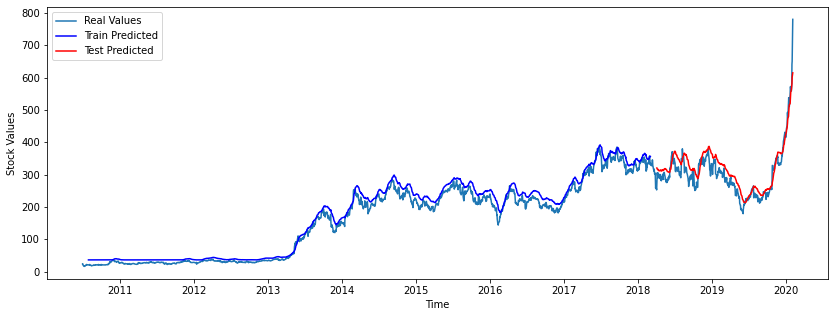

In [66]:
# Train ve Test Tahminlerini ayrı ayrı görselleştirme işlemi
plt.figure(figsize=(14,5))
plt.plot(result_df, label = 'Real Values')
plt.plot(train_prediction_df["Predicted"], color = 'blue', label = "Train Predicted")
plt.plot(test_prediction_df["Predicted"], color = 'red', label = "Test Predicted")
plt.xlabel('Time')
plt.ylabel('Stock Values')
plt.legend()
plt.show()
